In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from wordcloud import WordCloud
from collections import Counter
from nltk.stem import PorterStemmer, LancasterStemmer

In [2]:
def read_articles(file_name):
    with open(file_name, "r") as handle:
        article_all_lines = handle.readlines()
    
    article_all_lines = [line.replace("\n", "NEWLINE") for line in article_all_lines]
    
    start_art_idx = []
    for idx, line in enumerate(article_all_lines):
        if line.startswith("@"):
            start_art_idx.append(idx)
    
    idx_parirs = list(zip(start_art_idx[:-1], start_art_idx[1:])) + [(start_art_idx[-1], None)]
    #print(idx_parirs)
    articles = []
    for s_idx, e_idx in idx_parirs:
        articles.append(article_all_lines[s_idx: e_idx])
    return articles

In [3]:
def look_for_field(field, lines_per_article):
    s_idx = -1
    for idx, line in enumerate(lines_per_article):
        if line.startswith(field + " "):
            s_idx = idx
    
    e_idx = s_idx
    idx = s_idx
    while True:
        idx += 1
        if lines_per_article[idx].startswith(" "):
            e_idx = idx
        else:
            break
    e_idx += 1
    return s_idx, e_idx

In [4]:
def extract_field(field, lines_per_article, newline_replace=None):
    s_idx, e_idx = look_for_field(field, lines_per_article)
    if s_idx == -1:
        return None
    
    extracted_lines = lines_per_article[s_idx: e_idx]
    
    extracted_lines = [line.replace(field, "") for line in extracted_lines]
    extracted_lines = [line.replace("=", "") for line in extracted_lines]

    extracted_lines = [line.replace("{", "") for line in extracted_lines]
    extracted_lines = [line.replace("},", "") for line in extracted_lines]
    extracted_lines = [line.replace("}", "") for line in extracted_lines]
    
    extracted_lines = [line.strip() for line in extracted_lines]
    
    if newline_replace is not None:
        extracted_lines = [line.replace("NEWLINE", newline_replace) for line in extracted_lines]
    
    return " ".join(extracted_lines)

In [5]:
def extract_fields(fields, lines_per_article, not_replace_newline=None):
    if not_replace_newline is None:
        not_replace_newline = []
    
    art = {}
    for field in fields:
        if field in not_replace_newline:
            art[field] = extract_field(field, lines_per_article, newline_replace=None)
        else:
            art[field] = extract_field(field, lines_per_article, newline_replace="")
    return art

In [6]:
def create_pub_df(bib_file, fields, not_replace_newline=None):
    articles = read_articles(bib_file)
    df = [extract_fields(fields, art, not_replace_newline=not_replace_newline) for art in articles]
    return pd.DataFrame(df)

In [7]:
NAME_ALIAS = ["Nguyen-Thoi, T", "Trung Nguyen-Thoi", "Trung , NT", "Thoi, TN", "Nguyen-Thoi", "Trung"]

INST_KEYWORDS = ["Univ", "Indian Inst", "Nitte Meenakshi Inst"]

In [8]:
def is_NTT(name, name_alias=NAME_ALIAS):
    return name in name_alias


def is_NTT_in_phrase(phrase, name_alias=NAME_ALIAS):
    for name in name_alias:
        if name in phrase:
            return True
    return False


def is_Univ_in_phrase(phrase, inst_keywords=INST_KEYWORDS):
    for inst in inst_keywords:
        if inst in phrase:
            return True
    
    return False


def year_from_EAD(s):
    """extract year from Early Access Date"""
    if s is None:
        return None
    return s.split()[-1]


def corr_auth_from_affil(s):
    if s is None:
        return None
    keyword = "(Corresponding Author)"
    entries = s.split("NEWLINE")
    corr_auths = []
    for e in entries:
        if keyword in e:
            name = e.split(keyword)[0].strip()
            corr_auths.append(name)

    if len(corr_auths) == 0:
        return None
    else:
        return ";".join(set(corr_auths))
    
    
def is_NTT_corr_auth(s, name_alias=NAME_ALIAS):
    if s is None:
        return False
    
    for n in name_alias:
        if n in s:
            return True
    return False


def country_all(s):
    if s is None:
        return None
    lines = s.split("NEWLINE")
    countries = []
    for line in lines:
        words = line.strip().split(",")
        
        c = words[0] + ";" + words[-1][:-1]
        countries.append(c)
    
    countries = list(set(countries))
    
    countries = [c.split(";")[-1] for c in countries]
    countries = [c.strip() for c in countries if c.strip() != ""]
    
    if len(countries) == 0:
        return None
    else:
        return ";".join(countries)


def country_of_collab(s, name_alias=NAME_ALIAS):
    if s is None:
        return None
    lines = s.split("NEWLINE")
    lines = [line for line in lines if not is_NTT_in_phrase(line)]
    
    countries = []
    for line in lines:
        words = line.strip().split(",")
        
        c = words[0] + ";" + words[-1][:-1]
        countries.append(c)
    
    countries = list(set(countries))
    
    #countries = [phrase for phrase in countries if not is_NTT_in_phrase(phrase)]
    countries = [c.split(";")[-1] for c in countries]
    countries = [c.strip() for c in countries if c.strip() != ""]
    
    countries = [c if "USA" not in c else "USA" for c in countries]
    countries = [c if "Viet Nam" not in c else "Vietnam" for c in countries]
    
    if len(countries) == 0:
        return None
    else:
        return ";".join(countries)
    
    
def university_all(s):
    if s is None:
        return None
    lines = s.split("NEWLINE")
    
    univs = []
    for line in lines:
        words = line.split(",")
        for word in words:
            if is_Univ_in_phrase(word):
                univs.append(word.strip())
    
    if len(univs) == 0:
        return None
    else:
        return ";".join(univs)
    

def university_collab(s):
    if s is None:
        return None
    lines = s.split("NEWLINE")
    lines = [line for line in lines if not is_NTT_in_phrase(line)]
    
    univs = []
    for line in lines:
        words = line.split(",")
        for word in words:
            if is_Univ_in_phrase(word):
                univs.append(word.strip())
    
    if len(univs) == 0:
        return None
    else:
        return ";".join(univs)
    

def collaborator(s):
    if s is None:
        return None
    
    names = s.split(" and ")
    names = [name for name in names if not is_NTT_in_phrase(name)]
    
    names = [name.strip() for name in names]
    
    if len(names) == 0:
        return None
    else:
        return "AND".join(names)

In [9]:
BIB_FILE = "Nguyen_Thoi_Trung.bib"
FIELDS = ["Author", "Title", "Journal", "Year", "Early Access Date", "Abstract", "Affiliation",
          "Keywords-Plus", "Keywords", "Research-Areas", "Web-of-Science-Categories",
         "Author-Email", "Journal-ISO"]

In [10]:
df = create_pub_df(BIB_FILE, FIELDS, not_replace_newline=["Affiliation"])

df["Early Access Date"] = df["Early Access Date"].apply(year_from_EAD)

df["Year"] = np.where(~df["Year"].isnull(), df["Year"], df["Early Access Date"])
df["Year"] = df["Year"].astype("int")

df["Corresponding Author"] = df["Affiliation"].apply(corr_auth_from_affil)

df["is_NTT_corr_auth"] = df["Corresponding Author"].apply(is_NTT_corr_auth)

df["Country_All"] = df["Affiliation"].apply(country_all)

df["Country_Collab"] = df["Affiliation"].apply(country_of_collab)

df["Univ_All"] = df["Affiliation"].apply(university_all)

df["Univ_Collab"] = df["Affiliation"].apply(university_collab)

df["Collaborator"] = df["Author"].apply(collaborator)

print(df.shape)
df.head()

(221, 20)


,Author,Title,Journal,Year,Early Access Date,Abstract,Affiliation,Keywords-Plus,Keywords,Research-Areas,Web-of-Science-Categories,Author-Email,Journal-ISO,Corresponding Author,is_NTT_corr_auth,Country_All,Country_Collab,Univ_All,Univ_Collab,Collaborator
0,"Nghia Nguyen-Huu and Pistora, Jaromir and Cada...",Ultra-Wide Spectral Bandwidth and Enhanced Abs...,IEEE JOURNAL OF SELECTED TOPICS IN QUANTUM ELE...,2021,None,"Graphene, a two-dimensional monatomic layer of...","Nghia, NH (Corresponding Author), Ton Duc Than...",EFFICIENCY LIGHT-ABSORPTION; MAGNETIC POLARITO...,Gratings; Graphene; Absorption; Bandwidth; Fil...,Engineering; Physics; Optics,"Engineering, Electrical \& Electronic; Quantum...",nguyenhuunghia@tdtu.edu.vn jaromir.pistora@vsb...,IEEE J. Sel. Top. Quantum Electron.,"Nghia, NH",False,Vietnam;Vietnam;England;Peoples R China;Englan...,Vietnam;Vietnam;England;Peoples R China;Englan...,Ton Duc Thang Univ;Ton Duc Thang Univ;Ton Duc ...,Ton Duc Thang Univ;Ton Duc Thang Univ;Ton Duc ...,"Nghia Nguyen-HuuANDPistora, JaromirANDCada, Mi..."
1,"Dinh-Cong, D. and Van Hoa, Ngo and Nguyen-Thoi...",An effective optimization-based parameterized ...,ENGINEERING WITH COMPUTERS,2020,None,The framework of parameterized interval analys...,"Nguyen-Thoi, T (Corresponding Author), Ton Duc...",FINITE-ELEMENT-ANALYSIS; STOCHASTIC-ANALYSIS; ...,Parameterized interval analysis; Interval fini...,Computer Science; Engineering,"Computer Science, Interdisciplinary Applicatio...",dinhcongdu@tdtu.edu.vn ngovanhoa@tdtu.edu.vn n...,Eng. Comput.,"Nguyen-Thoi, T",True,Vietnam;Vietnam;Vietnam,Vietnam;Vietnam,Ton Duc Thang Univ;Ton Duc Thang Univ;Ton Duc ...,Ton Duc Thang Univ;Ton Duc Thang Univ,"Dinh-Cong, D.ANDVan Hoa, Ngo"
2,"Vinyas, M. and Harursampath, D. and Nguyen-Tho...",Influence of active constrained layer damping ...,DEFENCE TECHNOLOGY,2020,None,This article makes the first attempt in assess...,"Nguyen-Thoi, T (Corresponding Author), Ton Duc...",GEOMETRICALLY NONLINEAR VIBRATIONS; 1-3 PIEZOE...,Vibration control; Functionally graded; MEE pl...,Engineering,"Engineering, Multidisciplinary",vinyasmahesh@iisc.ac.in dinesh@aero.iisc.ernet...,Def. Technol.,"Nguyen-Thoi, T",True,India;Vietnam,India,Ton Duc Thang Univ;Ton Duc Thang Univ;Indian I...,Indian Inst Sci,"Vinyas, M.ANDHarursampath, D."
3,"Vo-Duy, T. and Truong, Tam T. and Nguyen-Quang...",A Type of Novel Nonlinear Distributions for Im...,INTERNATIONAL JOURNAL OF COMPUTATIONAL METHODS,2020,None,"So far, the carbon nanotube (CNT) distribution...","Nguyen-Thoi, T (Corresponding Author), Ton Duc...",HYBRID LAMINATED PLATES; FREE-VIBRATION; ISOGE...,CNT-reinforced composite beam; functionally gr...,Engineering; Mathematics,"Engineering, Multidisciplinary; Mathematics, I...",voduytrung@tdtu.edu.vn truongtam0303@gmail.com...,Int. J. Comput. Methods,"Nguyen-Thoi, T",True,Vietnam;Vietnam;Vietnam,Vietnam,Ton Duc Thang Univ;Ton Duc Thang Univ;Ton Duc ...,VNUHCM Univ Sci,"Vo-Duy, T.ANDTruong, Tam T.ANDNguyen-Quang, K...."
4,"Tran, Van-Ke and Tran, Thanh-Trung and Phung, ...",A Finite Element Formulation and Nonlocal Theo...,JOURNAL OF NANOMATERIALS,2020,None,This article presents a finite element method ...,"Pham, QH (Corresponding Author), Ton Duc Thang...",NONLINEAR FREE-VIBRATION; LAYERED GRAPHENE SHE...,None,Science \& Technology - Other Topics; Material...,Nanoscience \& Nanotechnology; Materials Scien...,tranke92@gmail.com tranthanh0212@gmail.com min...,J. Nanomater.,"Pham, QH",False,Vietnam;Vietnam,Vietnam,Ton Duc Thang Univ;Ton Duc Thang Univ;Le Quy D...,Ton Duc Thang Univ;Ton Duc Thang Univ,"Tran, Van-KeANDPhung, Minh-VanANDPham, Quoc-Hoa"


# Number of publications by year

Text(0.5, 1.0, 'NTT is a corresp. author')

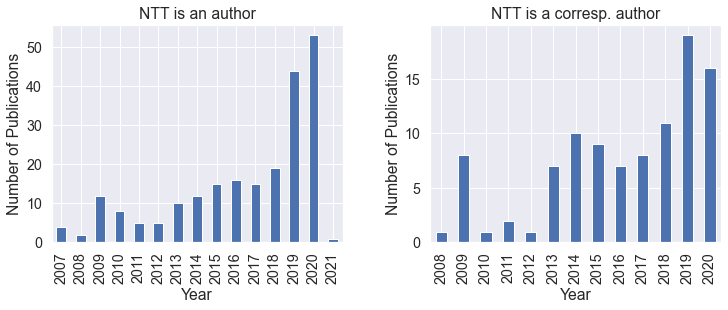

In [11]:
sns.set(font_scale=1.3)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)

df["Year"].value_counts().sort_index().plot(kind="bar", ax=ax[0])
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Number of Publications")
ax[0].set_title("NTT is an author")

df.loc[df["is_NTT_corr_auth"] == True ,"Year"].value_counts().sort_index().plot(kind="bar", ax=ax[1])
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Number of Publications")
ax[1].set_title("NTT is a corresp. author")

In [12]:
df_before_2019 = df[df["Year"] < 2019]
df_from_2019 = df[df["Year"] >= 2019]

# Collaborators

In [13]:
def make_list_collaborators(df):
    ser = df["Collaborator"]
    collaborators = []
    for line in ser.values:
        collabs = line.split("AND")
        collabs = [c.strip() for c in collabs]
        
        collaborators.extend(collabs)
    return collaborators

Text(0.5, 1.0, 'Collaborators from 2019')

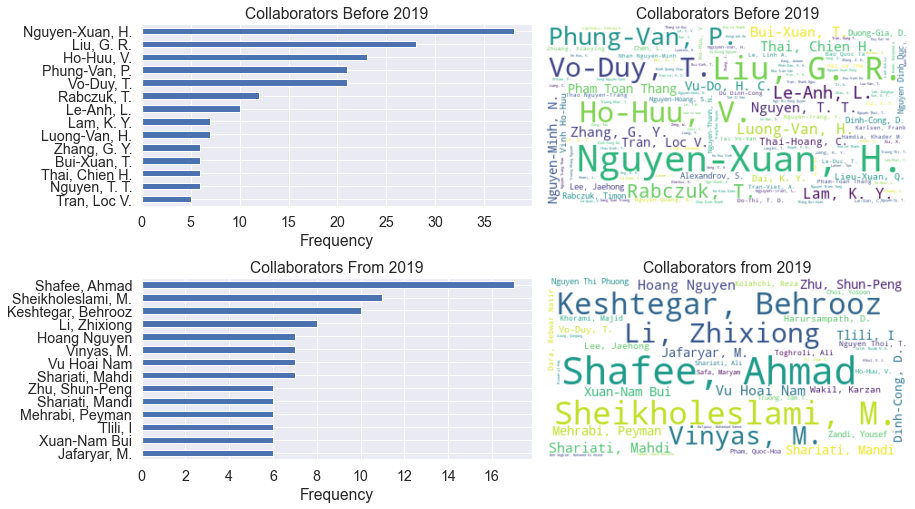

In [70]:
collab_b2019 = make_list_collaborators(df_before_2019)
collab_f2019 = make_list_collaborators(df_from_2019)

collab_count_b2019 = pd.Series(collab_b2019).value_counts()
collab_count_f2019 = pd.Series(collab_f2019).value_counts()


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
plt.subplots_adjust(wspace=0.0)
plt.subplots_adjust(hspace=0.4)

collab_count_b2019[:14].sort_values(ascending=True).plot(kind="barh", ax=ax[0, 0])
ax[0, 0].set_title("Collaborators: Before 2019")
ax[0, 0].set_xlabel("Frequency")

collab_count_f2019[:14].sort_values(ascending=True).plot(kind="barh", ax=ax[1, 0])
ax[1, 0].set_title("Collaborators: From 2019")
ax[1, 0].set_xlabel("Frequency")


wcld_b2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(collab_b2019))
ax[0, 1].imshow(wcld_b2019, interpolation="bilinear")
ax[0, 1].axis("off")
ax[0, 1].set_title("Collaborators: Before 2019")

wcld_f2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(collab_f2019))
ax[1, 1].imshow(wcld_f2019, interpolation="bilinear")
ax[1, 1].axis("off")
ax[1, 1].set_title("Collaborators: From 2019")

# Institutes of collaborators

In [22]:
def make_list_universities(df):
    ser = df["Univ_Collab"]
    univs = []
    for line in ser.values:
        if line is not None:
            us = line.split(";")
            us = [c.strip() for c in us]
            
            univs.extend(us)
    return univs

Text(0.5, 1.0, 'Institutes of Collaborators: From 2019')

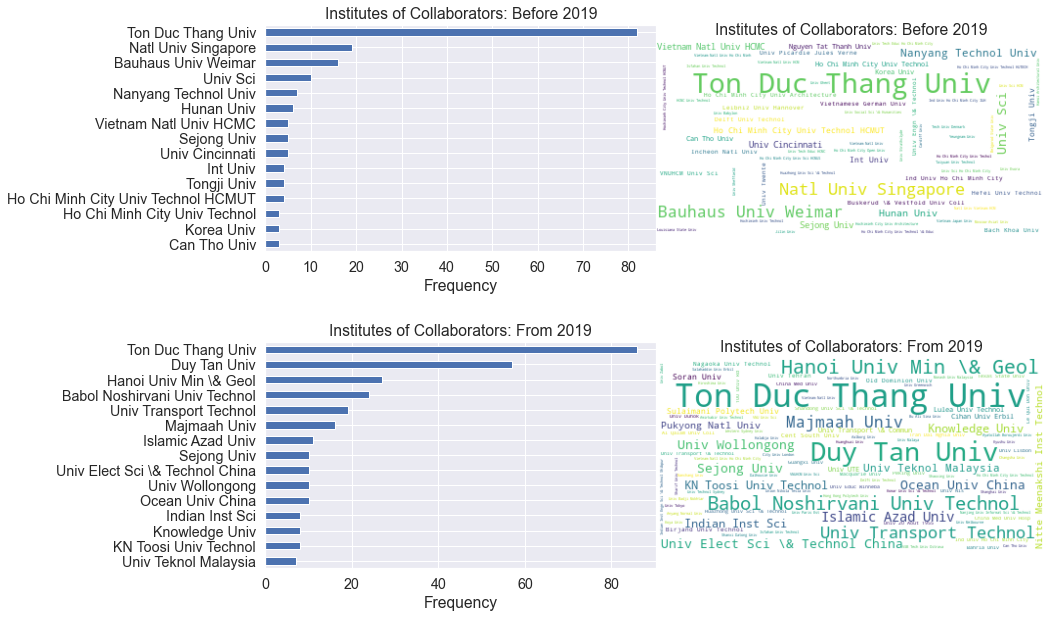

In [71]:
univ_b2019 = make_list_universities(df_before_2019)
univ_f2019 = make_list_universities(df_from_2019)

univ_count_b2019 = pd.Series(univ_b2019).value_counts()
univ_count_f2019 = pd.Series(univ_f2019).value_counts()



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.0)
plt.subplots_adjust(hspace=0.4)

univ_count_b2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[0, 0])
ax[0, 0].set_title("Institutes of Collaborators: Before 2019")
ax[0, 0].set_xlabel("Frequency")

univ_count_f2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[1, 0])
ax[1, 0].set_title("Institutes of Collaborators: From 2019")
ax[1, 0].set_xlabel("Frequency")



wcld_b2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(univ_b2019))
ax[0, 1].imshow(wcld_b2019, interpolation="bilinear")
ax[0, 1].axis("off")
ax[0, 1].set_title("Institutes of Collaborators: Before 2019")

wcld_f2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(univ_f2019))
ax[1, 1].imshow(wcld_f2019, interpolation="bilinear")
ax[1, 1].axis("off")
ax[1, 1].set_title("Institutes of Collaborators: From 2019")

# Countries of Collaborators

In [23]:
def make_list_countries(df):
    ser = df["Country_Collab"]
    countries = []
    for line in ser.values:
        if line is not None:
            coun = line.split(";")
            coun = [c.strip() for c in coun]
            
            countries.extend(coun)
    return countries

Text(0.5, 1.0, 'Countries of Collaborators: From 2019')

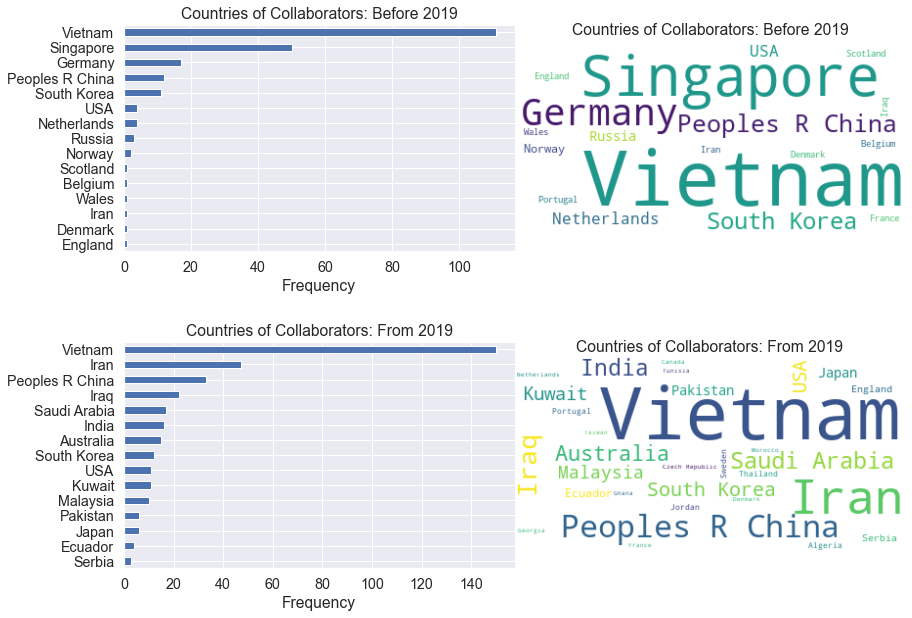

In [72]:
country_b2019 = make_list_countries(df_before_2019)
country_f2019 = make_list_countries(df_from_2019)

country_count_b2019 = pd.Series(country_b2019).value_counts()
country_count_f2019 = pd.Series(country_f2019).value_counts()


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.0)
plt.subplots_adjust(hspace=0.4)

country_count_b2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[0, 0])
ax[0, 0].set_title("Countries of Collaborators: Before 2019")
ax[0, 0].set_xlabel("Frequency")

country_count_f2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[1, 0])
ax[1, 0].set_title("Countries of Collaborators: From 2019")
ax[1, 0].set_xlabel("Frequency")


wcld_b2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(country_b2019))
ax[0, 1].imshow(wcld_b2019, interpolation="bilinear")
ax[0, 1].axis("off")
ax[0, 1].set_title("Countries of Collaborators: Before 2019")

wcld_f2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(country_f2019))
ax[1, 1].imshow(wcld_f2019, interpolation="bilinear")
ax[1, 1].axis("off")
ax[1, 1].set_title("Countries of Collaborators: From 2019")


# Publishing Journals

Text(0.5, 1.0, 'Publishing Journals From 2019')

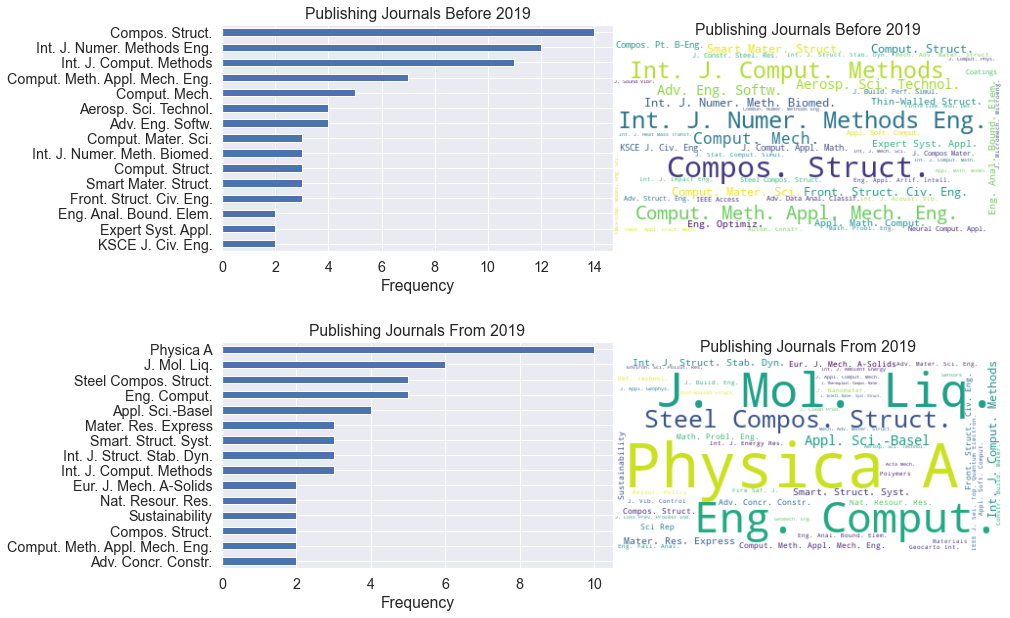

In [73]:
journal_b2019 = df_before_2019["Journal-ISO"].values.tolist()
journal_f2019 = df_from_2019["Journal-ISO"].values.tolist()

journal_b2019 = [j for j in journal_b2019 if j is not None]
journal_f2019 = [j for j in journal_f2019 if j is not None]

journal_count_b2019 = pd.Series(journal_b2019).value_counts()
journal_count_f2019 = pd.Series(journal_f2019).value_counts()


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.0)
plt.subplots_adjust(hspace=0.4)

journal_count_b2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[0, 0])
ax[0, 0].set_title("Publishing Journals: Before 2019")
ax[0, 0].set_xlabel("Frequency")

journal_count_f2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[1, 0])
ax[1, 0].set_title("Publishing Journals: From 2019")
ax[1, 0].set_xlabel("Frequency")


wcld_b2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(journal_b2019))
ax[0, 1].imshow(wcld_b2019, interpolation="bilinear")
ax[0, 1].axis("off")
ax[0, 1].set_title("Publishing Journals: Before 2019")

wcld_f2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(journal_f2019))
ax[1, 1].imshow(wcld_f2019, interpolation="bilinear")
ax[1, 1].axis("off")
ax[1, 1].set_title("Publishing Journals: From 2019")


# Research Areas

Text(0.5, 1.0, 'Research Areas From 2019')

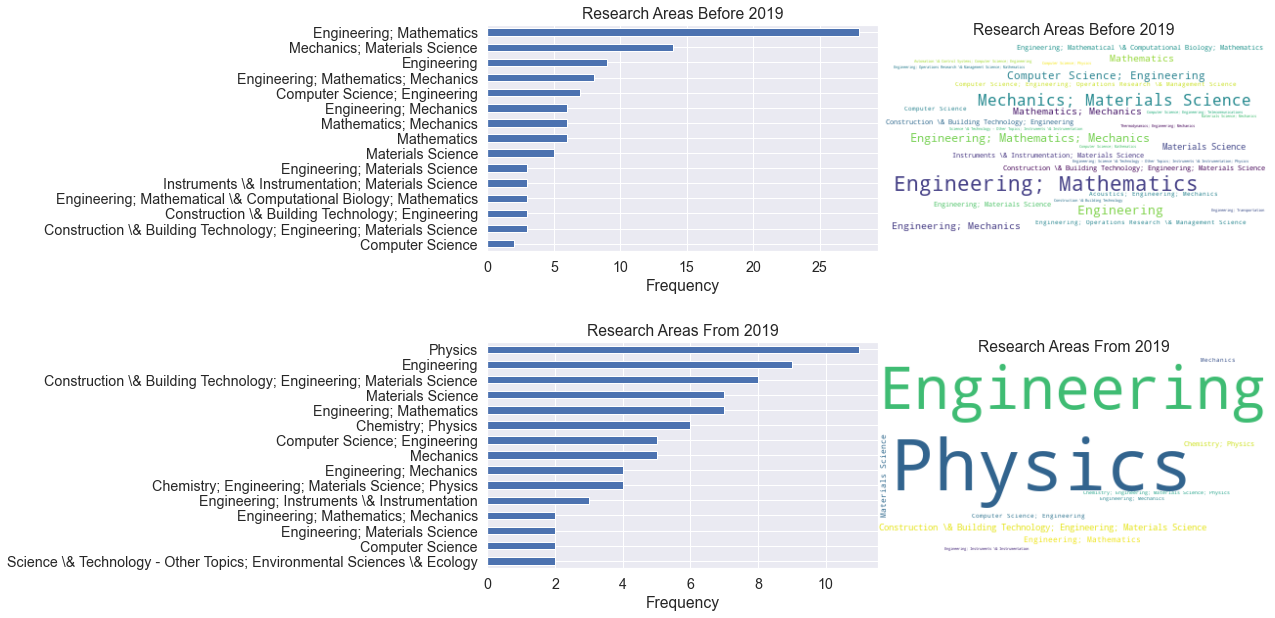

In [74]:
ra_b2019 = df_before_2019["Research-Areas"].values.tolist()
ra_f2019 = df_from_2019["Research-Areas"].values.tolist()

ra_count_b2019 = pd.Series(ra_b2019).value_counts()
ra_count_f2019 = pd.Series(ra_f2019).value_counts()


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.0)
plt.subplots_adjust(hspace=0.4)

ra_count_b2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[0, 0])
ax[0, 0].set_title("Research Areas: Before 2019")
ax[0, 0].set_xlabel("Frequency")

ra_count_f2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[1, 0])
ax[1, 0].set_title("Research Areas: From 2019")
ax[1, 0].set_xlabel("Frequency")


wcld_b2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(ra_b2019))
ax[0, 1].imshow(wcld_b2019, interpolation="bilinear")
ax[0, 1].axis("off")
ax[0, 1].set_title("Research Areas: Before 2019")

wcld_f2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(ra_f2019))
ax[1, 1].imshow(wcld_f2019, interpolation="bilinear")
ax[1, 1].axis("off")
ax[1, 1].set_title("Research Areas: From 2019")


# Web-of-Science Categories

Text(0.5, 0, 'Frequency')

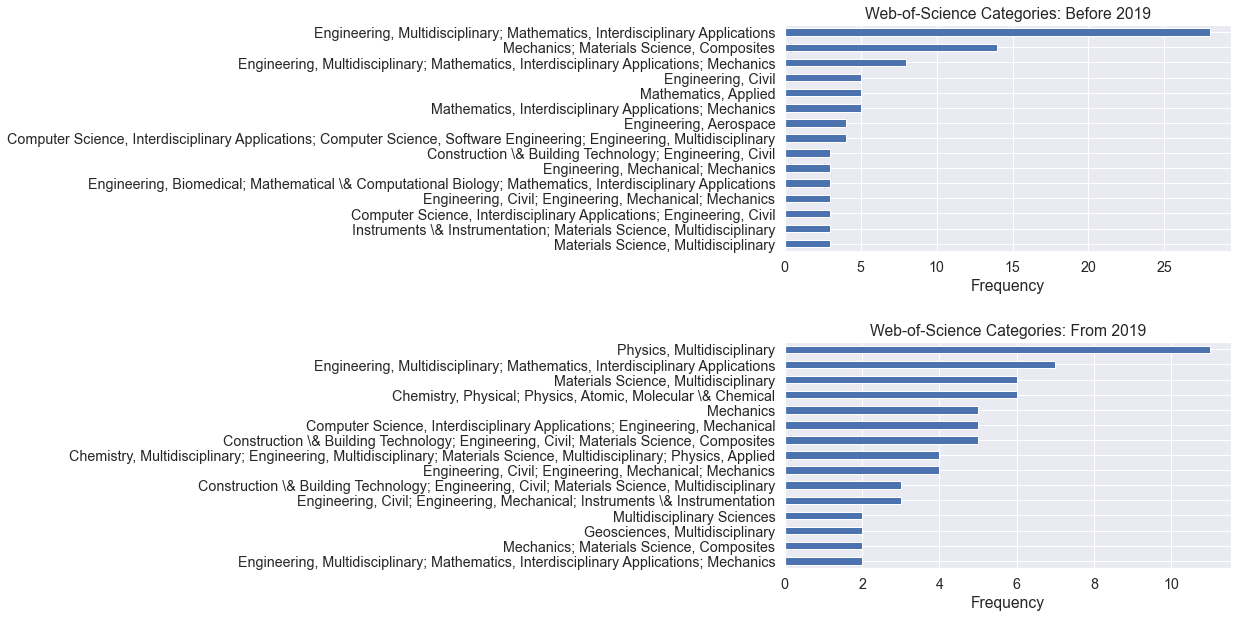

In [82]:
wos_cat_b2019 = df_before_2019["Web-of-Science-Categories"].values.tolist()
wos_cat_f2019 = df_from_2019["Web-of-Science-Categories"].values.tolist()

wos_cat_count_b2019 = pd.Series(wos_cat_b2019).value_counts()
wos_cat_count_f2019 = pd.Series(wos_cat_f2019).value_counts()


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))
plt.subplots_adjust(wspace=0.0)
plt.subplots_adjust(hspace=0.4)

wos_cat_count_b2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[0])
ax[0].set_title("Web-of-Science Categories: Before 2019")
ax[0].set_xlabel("Frequency")

wos_cat_count_f2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[1])
ax[1].set_title("Web-of-Science Categories: From 2019")
ax[1].set_xlabel("Frequency")


#wcld_b2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(wos_cat_b2019))
#ax[1].imshow(wcld_b2019, interpolation="bilinear")
#ax[1].axis("off")
#ax[1].set_title("Web-of-Science Categories: Before 2019")

#wcld_f2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(wos_cat_f2019))
#ax[3].imshow(wcld_f2019, interpolation="bilinear")
#ax[3].axis("off")
#ax[3].set_title("Web-of-Science Categories: From 2019")

# Key words

In [107]:
def make_list_keywords(df):
    ser = df["Keywords"]
    kws = []
    for line in ser.values:
        if line is not None:
            kw = line.split(";")
            kw = [c.strip() for c in kw]
            kw = [c.lower() for c in kw]
            
            kws.extend(kw)
    return kws


Text(0.5, 1.0, 'Keywords: From 2019')

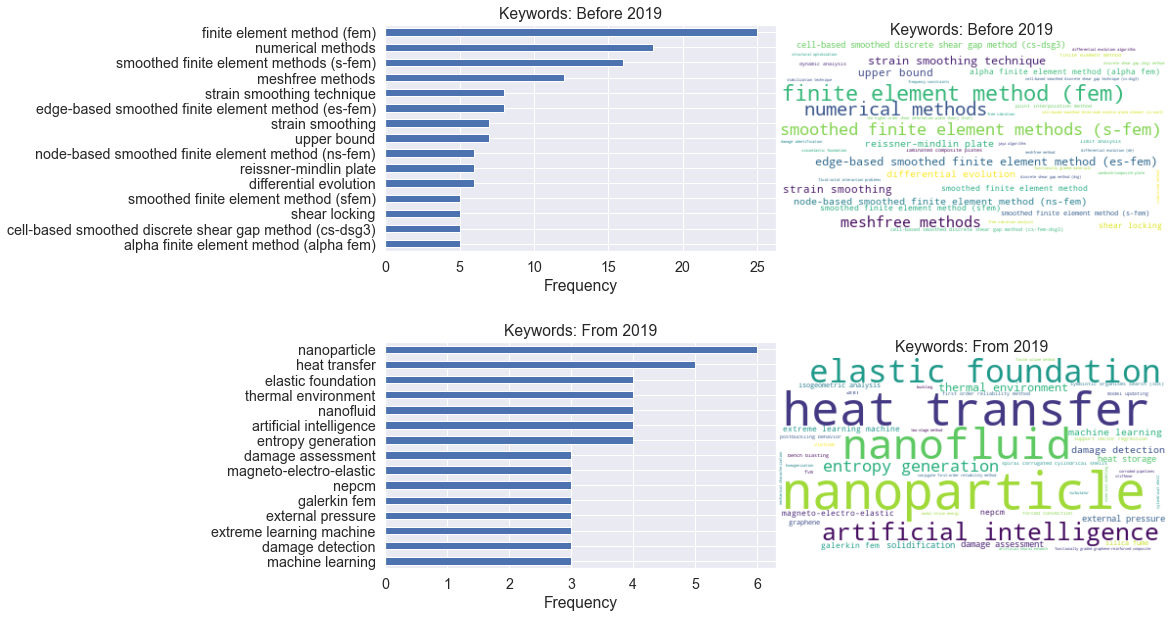

In [113]:
kw_b2019 = make_list_keywords(df_before_2019) 
kw_f2019 = make_list_keywords(df_from_2019)

kw_count_b2019 = pd.Series(kw_b2019).value_counts()
kw_count_f2019 = pd.Series(kw_f2019).value_counts()


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.0)
plt.subplots_adjust(hspace=0.4)

kw_count_b2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[0, 0])
ax[0, 0].set_title("Keywords: Before 2019")
ax[0, 0].set_xlabel("Frequency")

kw_count_f2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[1, 0])
ax[1, 0].set_title("Keywords: From 2019")
ax[1, 0].set_xlabel("Frequency")


wcld_b2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(kw_b2019))
ax[0, 1].imshow(wcld_b2019, interpolation="bilinear")
ax[0, 1].axis("off")
ax[0, 1].set_title("Keywords: Before 2019")

wcld_f2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(kw_f2019))
ax[1, 1].imshow(wcld_f2019, interpolation="bilinear")
ax[1, 1].axis("off")
ax[1, 1].set_title("Keywords: From 2019")


# Keywords Plus

In [108]:
def make_list_keywords_plus(df):
    ser = df["Keywords-Plus"]
    kws = []
    for line in ser.values:
        if line is not None:
            kw = line.split(";")
            kw = [c.strip() for c in kw]
            kw = [c.lower() for c in kw]
            
            kws.extend(kw)
    return kws

Text(0.5, 1.0, 'Keywords Plus: From 2019')

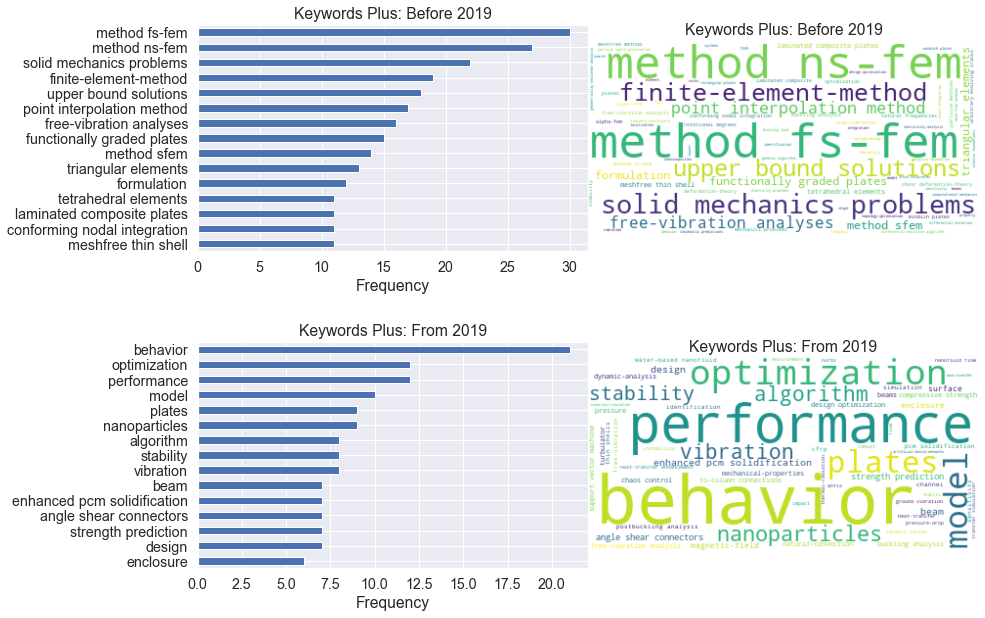

In [114]:
kwp_b2019 = make_list_keywords_plus(df_before_2019) 
kwp_f2019 = make_list_keywords_plus(df_from_2019)

kwp_count_b2019 = pd.Series(kwp_b2019).value_counts()
kwp_count_f2019 = pd.Series(kwp_f2019).value_counts()


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.0)
plt.subplots_adjust(hspace=0.4)

kwp_count_b2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[0, 0])
ax[0, 0].set_title("Keywords Plus: Before 2019")
ax[0, 0].set_xlabel("Frequency")

kwp_count_f2019[:15].sort_values(ascending=True).plot(kind="barh", ax=ax[1, 0])
ax[1, 0].set_title("Keywords Plus: From 2019")
ax[1, 0].set_xlabel("Frequency")


wcld_b2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(kwp_b2019))
ax[0, 1].imshow(wcld_b2019, interpolation="bilinear")
ax[0, 1].axis("off")
ax[0, 1].set_title("Keywords Plus: Before 2019")

wcld_f2019 = WordCloud(background_color="white").generate_from_frequencies(Counter(kwp_f2019))
ax[1, 1].imshow(wcld_f2019, interpolation="bilinear")
ax[1, 1].axis("off")
ax[1, 1].set_title("Keywords Plus: From 2019")